# FFT Phase Correlation
> How to use FFT Phase Correlation to find the relative translation between two images.

- toc: true 
- badges: true
- comments: true
- categories: [Computer Vision]
- image: images/2020-12-20-FFT-Phase-Correlation-Rotation/header.jpg


# Using Polar and Log-Polar Transformations for Registration


Phase correlation (``registration.phase_cross_correlation``) is an efficient
method for determining translation offset between pairs of similar images.
However this approach relies on a near absence of rotation/scaling differences
between the images, which are typical in real-world examples.

To recover rotation and scaling differences between two images, we can take
advantage of two geometric properties of the log-polar transform and the
translation invariance of the frequency domain. First, rotation in Cartesian
space becomes translation along the angular coordinate ($\theta$) axis
of log-polar space. Second, scaling in Cartesian space becomes translation
along the radial coordinate ($\rho = \ln\sqrt{x^2 + y^2}$) of log-polar
space. Finally, differences in translation in the spatial domain do not impact
magnitude spectrum in the frequency domain.

In this series of examples, we build on these concepts to show how the
log-polar transform ``transform.warp_polar`` can be used in conjunction with
phase correlation to recover rotation and scaling differences between two
images that also have a translation offset.


Recover rotation difference with a polar transform
==================================================

In this first example, we consider the simple case of two images that only
differ with respect to rotation around a common center point. By remapping
these images into polar space, the rotation difference becomes a simple
translation difference that can be recovered by phase correlation.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

import skimage.io
from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar, rotate, rescale

from skimage.color import rgb2gray
from skimage.filters import window, difference_of_gaussians
from scipy.fftpack import fft2, fftshift

import scipy 

import cv2

plt.rcParams['figure.figsize'] = [10, 10]

## The Log Polar Transform

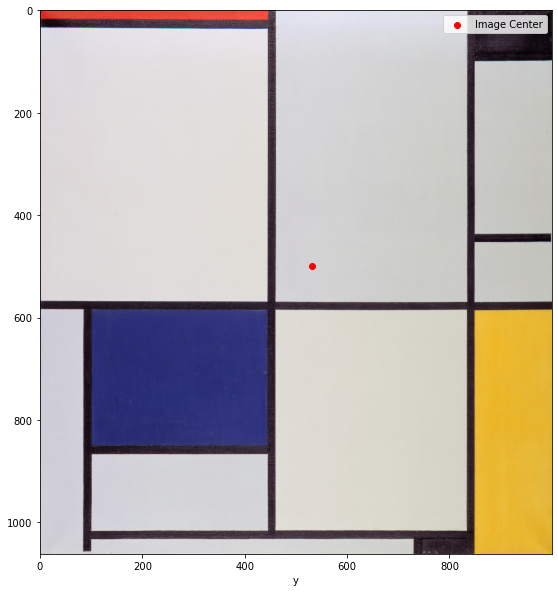

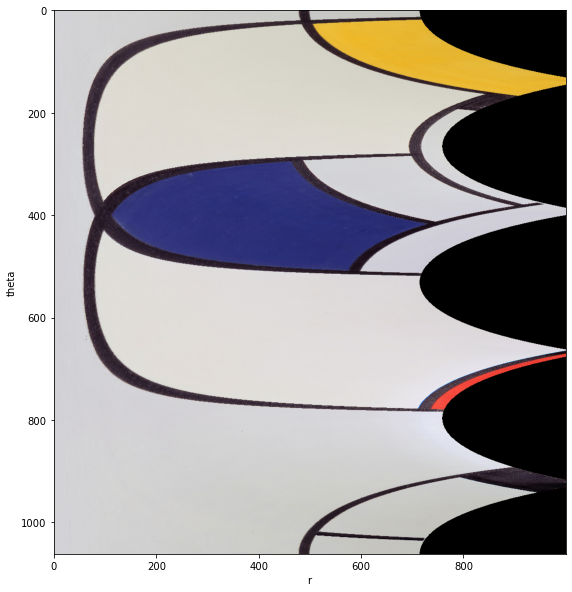

In [31]:
mondarin = skimage.io.imread('data/2020-12-20-FFT-Phase-Correlation-Rotation/mondrian.jpg')

shape = mondarin.shape

plt.title('Original')
plt.scatter(shape[0]/2,shape[1]/2,color='r',label = 'Image Center')
plt.imshow(mondarin)
plt.legend()
plt.xlabel('x')
plt.xlabel('y')
plt.show()

monarin_warped = warp_polar(mondarin, radius=700, output_shape=shape, scaling='linear', order=0, multichannel=True)

plt.title('Warped')
plt.imshow(monarin_warped)
plt.xlabel('r')
plt.ylabel('theta')
plt.show()


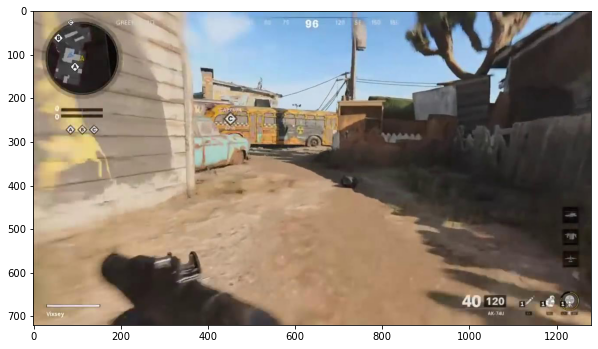

In [2]:
frame = skimage.io.imread('data/2020-12-19-FFT-Phase-Correlation/Frame.jpg')
plt.imshow(frame)
plt.show()

image = frame[30:185,35:190]

In [3]:
angle = 30
scale = 1.0
shiftr = 10
shiftc = 20

img1 = rgb2gray(frame[30:185,35:190])

result = scipy.ndimage.fourier_shift(np.fft.fft2(img1), shift=(shiftc,shiftr))
result = np.fft.ifft2(result).real

img2 = rotate(result, angle)


Find Rotation

In [4]:
def fft_phase_correlation(img1, img2):
    
    # window images
    img1_wimage = img1 * window('hann', img1.shape)
    img2_wimage = img2 * window('hann', img2.shape)

    # window images
    img1_wimage = img1 * window('hann', img1.shape)
    img2_wimage = img2 * window('hann', img2.shape)

    #Compute the corss power spectrum
    cross_power_spectrum = (img1_fs * np.conjugate(img2_fs)) / np.abs(img1_fs * np.conjugate(img2_fs))

    r = np.fft.ifft2(cross_power_spectrum).real

    r = np.fft.fftshift(r)
    
    return(r)

In [5]:
# window images
img1_wimage = img1 * window('hann', img1.shape)
img2_wimage = img2 * window('hann', img2.shape)

# work with shifted FFT magnitudes
img1_fs = np.abs(fftshift(fft2(img1_wimage)))
img2_fs = np.abs(fftshift(fft2(img2_wimage)))

In [6]:
# Create log-polar transformed FFT mag images and register
shape = img1_fs.shape
radius = shape[0] // 8  # only take lower frequencies

img1_fs = warp_polar(img1_fs, radius=radius, output_shape=shape, scaling='log', order=0)
img2_fs = warp_polar(img2_fs, radius=radius, output_shape=shape, scaling='log', order=0)

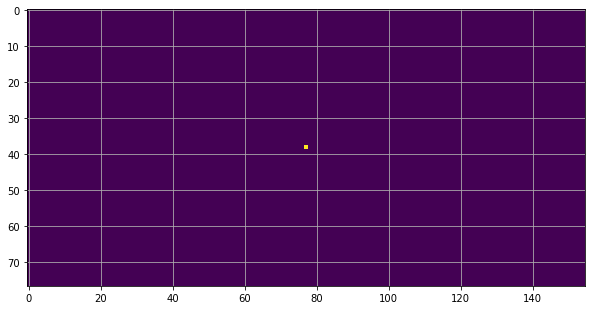

In [10]:
img1_fs = img1_fs[:shape[0] // 2, :]  # only use half of FFT
img2_fs = img2_fs[:shape[0] // 2, :]


#Compute the corss power spectrum
cross_power_spectrum = (img1_fs * np.conjugate(img2_fs)) / np.abs(img1_fs * np.conjugate(img2_fs))

r = np.fft.ifft2(cross_power_spectrum).real

r = np.fft.fftshift(r)

plt.imshow(r)
plt.grid()
plt.show()

In [8]:
# Use translation parameters to calculate rotation and scaling parameters
#shiftr, shiftc = shifts[:2]

[py,px] = np.argwhere(r==r.max())[0]



theta = (360 / shape[0]) * shiftr

img2_rotated = rotate(img2, -theta)

#Find translation
shift, error, phasediff = phase_cross_correlation(img1, img2_rotated, upsample_factor=10)

NameError: name 'shifts' is not defined

Align image

In [ ]:
rotated = rotate(img2, -theta)

#Find translation
#shifts, error, phasediff = phase_cross_correlation(img1, rotated, upsample_factor=10)
shifts = fft_phase_correlation(img1, img2):




img2_rotated = rotate(img2, -theta)


print(theta, shifts)


plt.imshow(np.dstack([img1,img2,np.zeros(img1.shape)]))
plt.show()


shiftr = shifts[0]
shiftc = shifts[1]

result = scipy.ndimage.fourier_shift(np.fft.fft2(img2_rotated), shift=(shiftr,shiftc))
result = np.fft.ifft2(result).real
translated = result


plt.imshow(np.dstack([img1,translated,np.zeros(translated.shape)]))
plt.show()